In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, join, vstack
import Euclid
from scipy.stats import wasserstein_distance
from scipy.signal import deconvolve
from scipy.fft import fft, ifft
from scipy.optimize import curve_fit
from tqdm.auto import tqdm

%erun Phosphoros

from PhzCLI.PlotSpecZComparison import compute_stats, displayHistogram

plt.style.use('seaborn')
plt.style.use('seaborn-notebook')

In [2]:
nnpz = Table.read('/home/aalvarez/Work/Data/PV/Prod/lsst/75769/NnpzLsst/output_file.fits', hdu=1)
len(nnpz)
mask = nnpz['FLAGS'] == 0
print(np.sum(mask), len(mask))
nnpz = nnpz[mask]

66240 85798


In [3]:
smooth = Table.read('/home/aalvarez/Work/Data/PV/Prod/lsst/75769/NnpzLsst/auto_kernel.fits', hdu=1)
len(smooth)

85798

In [4]:
pdz_bins = Table.read('/home/aalvarez/Work/Data/PV/Prod/lsst/75769/NnpzLsst/output_file.fits', hdu=2)
pdz_bins = pdz_bins['BINS_PDF']

In [5]:
phosphoros = Table.read('/home/aalvarez/Work/Data/PV/Calib/lsst_phosphoros.fits', hdu=1)
phosphoros.rename_column('ID', 'OBJECT_ID')
len(phosphoros)

85798

In [6]:
cross = join(nnpz, smooth, 'OBJECT_ID', table_names=['nnpz', 'smooth'])
cross = join(cross, phosphoros, 'OBJECT_ID', table_names=['nnpz', 'pho'])
len(cross)

66240

In [7]:
testing_idx = np.load('testing_idx.npy')

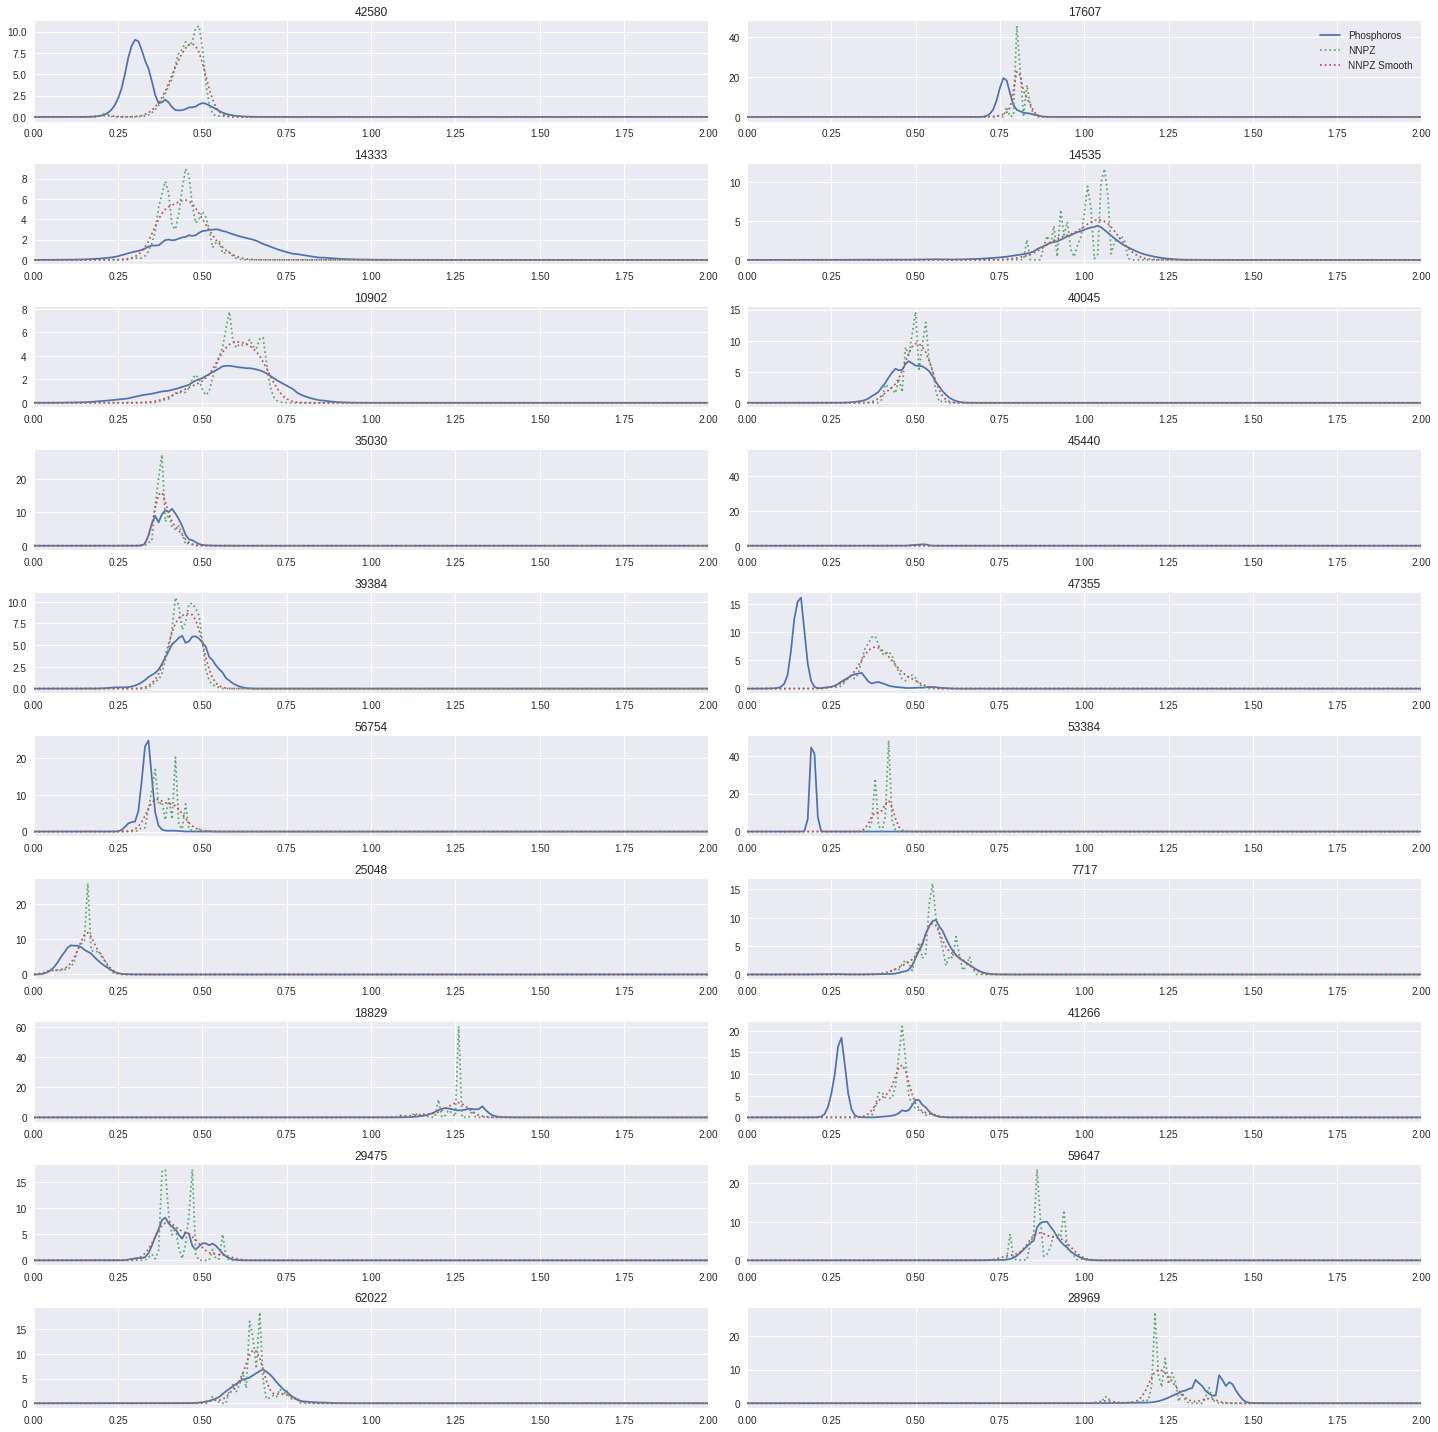

In [8]:
idxs = np.random.choice(testing_idx, size=20)

fig, axes = plt.subplots(ncols=2, nrows=10, figsize=(20, 20))
for i, ax in enumerate(axes.ravel()):
    row = cross[idxs[i]]
    ax.plot(pdz_bins, row['Z-1D-PDF'], linestyle='-', label='Phosphoros')
    ax.plot(pdz_bins, row['REDSHIFT_PDF_nnpz'], linestyle=':', label='NNPZ')
    ax.plot(pdz_bins, row['REDSHIFT_PDF_smooth'], linestyle=':', label='NNPZ Smooth')
    
    #ax.plot(pdz_bins[:300], row['REDSHIFT_PDF_KERNEL'][150:450], label='Kernel', linestyle=':', color='pink')
    
    ax.set_xlim(0, 2)
    ax.set_title(idxs[i])
    
axes[0, 1].legend()
plt.tight_layout()
plt.savefig('/home/aalvarez/Downloads/smooth_auto.pdf')
plt.show()

In [9]:
loss_peak = np.zeros(len(testing_idx))
loss = np.zeros_like(loss_peak)
for i, idx in enumerate(tqdm(testing_idx)):
    row = cross[idx]
    loss_peak[i] = wasserstein_distance(row['Z-1D-PDF'], row['REDSHIFT_PDF_nnpz'])
    loss[i] = wasserstein_distance(row['Z-1D-PDF'], row['REDSHIFT_PDF_smooth'])

  0%|          | 0/26496 [00:00<?, ?it/s]

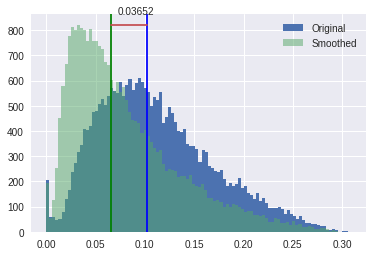

In [10]:
plt.figure()

peak_median = np.nanmedian(loss_peak)
smooth_median = np.nanmedian(loss)

bins = plt.hist(loss_peak, bins=100, label='Original')
plt.axvline(peak_median, color='blue')
bins = plt.hist(loss, bins=100, label='Smoothed', alpha=0.5)
plt.axvline(smooth_median, color='green')
plt.plot([smooth_median, peak_median], [np.max(bins[0])]*2)
plt.text(smooth_median*1.1, np.max(bins[0])*1.05, f'{peak_median - smooth_median:.5f}')
plt.legend()
plt.savefig('/home/aalvarez/Downloads/lsst_emd_auto.png')

In [11]:
len(testing_idx), peak_median, smooth_median

(26496, 0.10222402156870522, 0.06570653139524602)